In [1]:
import pandas as pd
import numpy as np 
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features = [
    #'question1_nouns',
    #'question2_nouns',
    #'q1_tok_words',
    #'q2_tok_words',
    'z_noun_match',
    'z_len1',
    'z_len2',
#     'z_word_len1',
#     'z_word_len2',
    'z_match_ratio',
#     'z_word_match',
#     'z_word_match_idf',
#     'z_tfidf_sum1',
#     'z_tfidf_sum2',
#     'z_tfidf_mean1',
#     'z_tfidf_mean2',
#     'z_tfidf_len1',
#     'z_tfidf_len2',
    'z_n_sim',
    
    'common_words_lemm',
    'n_sim_lemm',
    'n_sim_lemm_stop',
    's2v_sum_dist',
    's2v_ave_dist'
]

In [3]:
features_6w1h = [
#     'q1_what',
#     'q2_what',
#     'q1_when',
#     'q2_when',
#     'q1_why',
#     'q2_why',
#     'q1_where',
#     'q2_where',
#     'q1_who',
#     'q2_who',
#     'q1_which',
#     'q2_which',
#     'q1_how',
#     'q2_how',
    'what',
    'when',
    'why',
    'where',
    'who',
    'which',
    'how'
]

features.extend(features_6w1h)

In [4]:
features_clean = [
    'clean_lemm_stem_len1',
    'clean_lemm_stem_len2',
    'clean_lemm_stem_word_len1',
    'clean_lemm_stem_word_len2',
    'clean_lemm_stem_match_ratio',
    'clean_lemm_stem_word_match',
    'clean_lemm_stem_word_match_idf',
    'clean_lemm_stem_tfidf_sum1',
    'clean_lemm_stem_tfidf_sum2',
    'clean_lemm_stem_tfidf_mean1',
    'clean_lemm_stem_tfidf_mean2',
    'clean_lemm_stem_tfidf_len1',
    'clean_lemm_stem_tfidf_len2'
]

features.extend(features_clean)

In [5]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

def read_feature(t, features):
    key = 'id' if t == 'train' else 'test'
    data = pd.DataFrame(columns=[key])
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)), how='outer')
    return data

In [6]:
train = read_data('train', features)#[:100]

In [7]:
def balance_data_size(x, y):
    x_pos = x[y == 1]
    x_neg = x[y == 0]
    y_pos = y[y == 1]
    y_neg = y[y == 0]
    
    p = 0.17426778573248283
    while len(x_pos) / (len(x_pos) + len(x_neg)) > p:
        x_neg = pd.concat([x_neg, x_neg])
        y_neg = pd.concat([y_neg, y_neg])
    need_negs = int((1 - p) / p * len(x_pos))
    x_neg = x_neg[:need_negs]
    y_neg = y_neg[:need_negs]
  
    x = pd.concat([x_pos, x_neg])
    y = pd.concat([y_pos, y_neg])
    return (x, y)

In [8]:
def split_train_valid_correctly(train):
    new_train_ratio = 0.8

    def normalize_question(s):
        return str(s).lower().strip()

    from collections import defaultdict
    inverted_index = defaultdict(list)
    for index, row in train.iterrows():
        inverted_index[normalize_question(row['question1'])].append(index)
        inverted_index[normalize_question(row['question2'])].append(index)
    len(inverted_index)
    
    import random
    rows = list(train.iterrows())
    random.seed(810)
    random.shuffle(rows)
    new_train_indexes = set()
    for index, row in rows:
        if len(new_train_indexes) >= len(train) * new_train_ratio:
            break

        new_train_indexes.update(inverted_index[normalize_question(row['question1'])])
        new_train_indexes.update(inverted_index[normalize_question(row['question2'])])

    new_valid_indexes = [index for index, row in train.iterrows() if index not in new_train_indexes]

    new_train = train.iloc[list(new_train_indexes)]
    new_valid = train.iloc[list(new_valid_indexes)]

    print('size ratio')
    print(len(new_train_indexes) / len(train))
    print(len(new_valid_indexes) / len(train))

    print('duplicate ratio')
    print(sum(train.is_duplicate) / len(train))
    print(sum(new_train.is_duplicate) / len(new_train))
    print(sum(new_valid.is_duplicate) / len(new_valid))
    
    return (new_train, new_valid)

split_train, split_valid = split_train_valid_correctly(train)

x_train, y_train = balance_data_size(split_train[features], split_train['is_duplicate'])
x_valid, y_valid = balance_data_size(split_valid[features], split_valid['is_duplicate'])

print('balance')
print(sum(y_train) / len(y_train))
print(sum(y_valid) / len(y_valid))

size ratio
0.8
0.2
duplicate ratio
0.369197853026
0.40434156175
0.228623018131
balance
0.174267793299
0.174267991478


In [9]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.05
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 10
params["silent"] = 1
params["seed"] = 87978979

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s

[0]	train-logloss:0.666636	valid-logloss:0.664763
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.30732	valid-logloss:0.296951
[200]	train-logloss:0.27947	valid-logloss:0.290279
[300]	train-logloss:0.258876	valid-logloss:0.287924
[400]	train-logloss:0.243379	valid-logloss:0.286859
[500]	train-logloss:0.229913	valid-logloss:0.285897
[600]	train-logloss:0.218572	valid-logloss:0.285572
[700]	train-logloss:0.208113	valid-logloss:0.285288
[800]	train-logloss:0.198749	valid-logloss:0.285155
Stopping. Best iteration:
[787]	train-logloss:0.199737	valid-logloss:0.285112



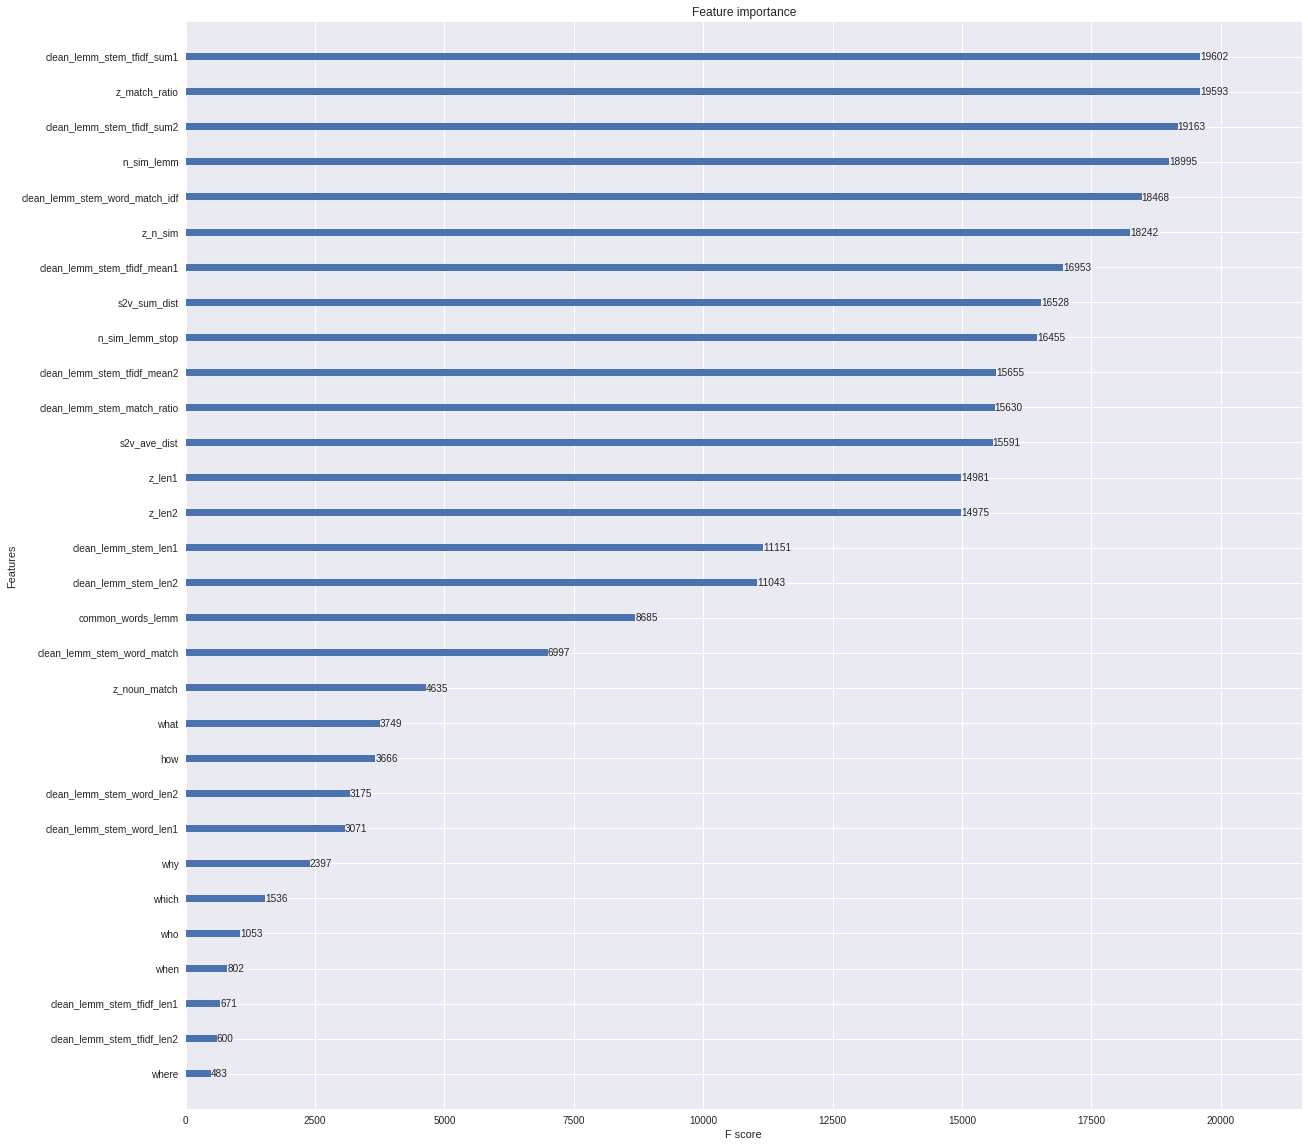

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
xgb.plot_importance(bst); plt.show()

In [11]:
test = read_data('test', features)#[:100]
sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[features]))

sub.to_csv('result_clean.csv', index=False)

In [12]:
ori_train_pred = bst.predict(xgb.DMatrix(train[features]))
ori_train_bin_pred = np.where(ori_train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(train.is_duplicate == ori_train_bin_pred) / len(train)))

accuracy: 0.8418412525662272


In [13]:
train_pred = bst.predict(xgb.DMatrix(split_train[features]))
train_bin_pred = np.where(train_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_train.is_duplicate == train_bin_pred) / len(split_train)))

accuracy: 0.8426438942343367


In [14]:
valid_pred = bst.predict(xgb.DMatrix(split_valid[features]))
valid_bin_pred = np.where(valid_pred < 0.5, 0, 1)
print('accuracy: {}'.format(sum(split_valid.is_duplicate == valid_bin_pred) / len(split_valid)))

accuracy: 0.8386306858937891


In [15]:
train['pred'] = ori_train_pred

def calc_score(row):
    return log_loss([row['is_duplicate']], [row['pred']], labels=[0, 1])

train['loss'] = train.apply(calc_score, axis=1)

In [16]:
text_features = [
    'q1_tokenized',
    'q2_tokenized',
    'question1_nouns',
    'question2_nouns',
    'q1_lemmatized',
    'q2_lemmatized',
    'q1_pos_tagged',
    'q2_pos_tagged',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

text_features_train = read_feature('train', text_features)

In [17]:
data = pd.merge(train, text_features_train, how='outer')

In [18]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_rows", 101)

In [19]:
data.sort_values(by='loss', ascending=False)[:1000].to_html('gao.html')

In [20]:
a = data.iloc[361387]

In [21]:
a

id                                361387                                                                                             
qid1                              491219                                                                                             
qid2                              491220                                                                                             
question1                         What ethnicity were the Moors of Sicily?                                                           
question2                         Who were the moors?                                                                                
is_duplicate                      1                                                                                                  
z_noun_match                      1                                                                                                  
z_len1                            40                          